# Velocity encoded spoiled GRE with laminar flow (sequential)

In this notebook the gradient waveforms used to instatiate the BlochOperate (corresponding to the repetition times of the gradient echo sequence) are evaluated sequentially. 

To this end a custom loop is used, which increments the repetition index on each call to the operator, which indexes the waveform of the corresponding TR. Furthermore, the magnetization and position are transfered to the subsequent TR, including a reseeding and pruning step to hande in- and out-flow.

The sequence is defined using CMRseq, and the meshed domain of the stenotic straight tube is provided as example resource. The particle trajectories are represented by a `FlowTrajectory` module, corresponding to laminar flow, which is internally called inside the Bloch simulation.

The main sections are
1. Imports
2. Sequence definition
3. Phantom setup
4. Simulation
5. Reconstruction

## Imports

In [ ]:
%pip install -U cmrseq==0.23 --index-url https://gitlab.ethz.ch/api/v4/projects/30300/packages/pypi/simple

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://gitlab.ethz.ch/api/v4/projects/30300/packages/pypi/simple

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import sys
sys.path.append("../")
sys.path.insert(0, "../../")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

import tensorflow as tf
gpu = tf.config.get_visible_devices("GPU")
if gpu:
    tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
from IPython.display import clear_output

import pyvista
from pint import Quantity
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import cmrsim
from cmrsim.utils import particle_properties as part_factory
import cmrseq

clear_output()

## Define Velocity encoded Spoiled GRE

### Configure Sequence parameters

In [3]:
# Define MR-system specifications
system_specs = cmrseq.SystemSpec(max_grad=Quantity(80, "mT/m"), 
                                 max_slew=Quantity(200., "mT/m/ms"),
                                 grad_raster_time=Quantity(0.01, "ms"),
                                 rf_raster_time=Quantity(0.01, "ms"),
                                 adc_raster_time=Quantity(0.01, "ms"))

# Define Fourier-Encoding parameters
fov = Quantity([41, 41], "mm")
matrix_size = (41, 41)
res = fov / matrix_size
print("Resolution:", res)

pulse_duration = Quantity(1.5, "ms")
adc_duration = Quantity(2, "ms")
flip_angle = Quantity(np.pi/6, "rad")
n_dummy = 0
readout_direction = np.array([0., 1., 0.])
slice_normal = np.array([0., 0., 1]) #xyz
slice_normal = slice_normal / np.linalg.norm(slice_normal)
slice_position = Quantity([0, 0, 0.081], "m")
slice_position_offset = Quantity(np.dot(slice_normal, slice_position.m_as("m")), "m")
slice_thickness = Quantity(5, "mm")
time_bandwidth_product = 4

# Define Reseeding slice parameters
seeding_slice_position = Quantity([0.0, 0.0, 0.081], "m")
seeding_slice_normal = np.array([0., 0., 1.])
seeding_slice_thickness = Quantity(5, "mm")
seeding_pixel_spacing = np.array((1e-3, 1e-3, 1e-3))  # resolution of seeding mesh, mm
seeding_slice_bb = Quantity([4, 4, 6], "cm")
seeding_particle_density = 4  # per 1/mm*3 default==16
lookup_map_spacing = np.array((1e-3, 1e-3, 1e-3))  # resolution of seeding mesh, mm


# Velocity encoding settings:
venc_max = Quantity(0.5, "m/s")
venc_direction = np.array([0., 0., 1.])  # in mps
venc_duration = Quantity(0, 'ms')  # Duration = 0 will result in shortest possible venc

Resolution: [1.0 1.0] millimeter


### Instantiate Sequence in MPS and insert VENC

In [4]:
sequence_list = cmrseq.seqdefs.sequences.flash(system_specs,
                                               slice_thickness=slice_thickness,
                                               flip_angle=flip_angle,
                                               pulse_duration=pulse_duration,
                                               time_bandwidth_product=time_bandwidth_product,
                                               matrix_size=matrix_size,
                                               inplane_resolution=res,
                                               adc_duration=adc_duration,
                                               echo_time=Quantity(1., "ms"),
                                               repetition_time=Quantity(16., "ms"),
                                               slice_position_offset=slice_position_offset)

crusher_area = Quantity(np.pi * 6, "rad") / system_specs.gamma_rad / res[0]


for idx, seq in enumerate(sequence_list):
    rf_sequence = cmrseq.Sequence(seq[0:3], system_specs, copy=True)
    
    venc_seq = cmrseq.seqdefs.velocity.bipolar(system_specs, venc=venc_max.to("m/s"),
                                               direction=venc_direction, duration=venc_duration)
    ro_sequence = cmrseq.Sequence(seq[3:-1], system_specs, copy=True)
    ro_sequence.shift_in_time(-rf_sequence["slice_select_0"].duration)
    crusher = cmrseq.bausteine.TrapezoidalGradient.from_dur_area(system_specs, orientation=np.array([0., 0., 1.]),
                                                                 duration=Quantity(2.5, "ms"), area=crusher_area.to("mT/m*ms"))
    ro_sequence.append(crusher)
    venc_seq.append(ro_sequence)
    rf_sequence.append(venc_seq)
    sequence_list[idx] = rf_sequence

CMRSeq - AutomaticOptimizationWarning: /Users/hjalmar/miniconda3/envs/tf/lib/python3.10/site-packages/cmrseq/core/bausteine/_adc.py:227
	+ Arguments were overritten due to violations of System specifications
	+ In SymmetricADC.from_centered_valid() modified duration to get a valid dwell time:
		duration=<Quantity(2, 'millisecond')>
		valid_duration=<Quantity(0.0, 'millisecond')>.
	+ To avoid this, make sure duration/num_samples is a multiple of system_specs.adc_raster_time


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

### Rotate gradients to XYZ and plot

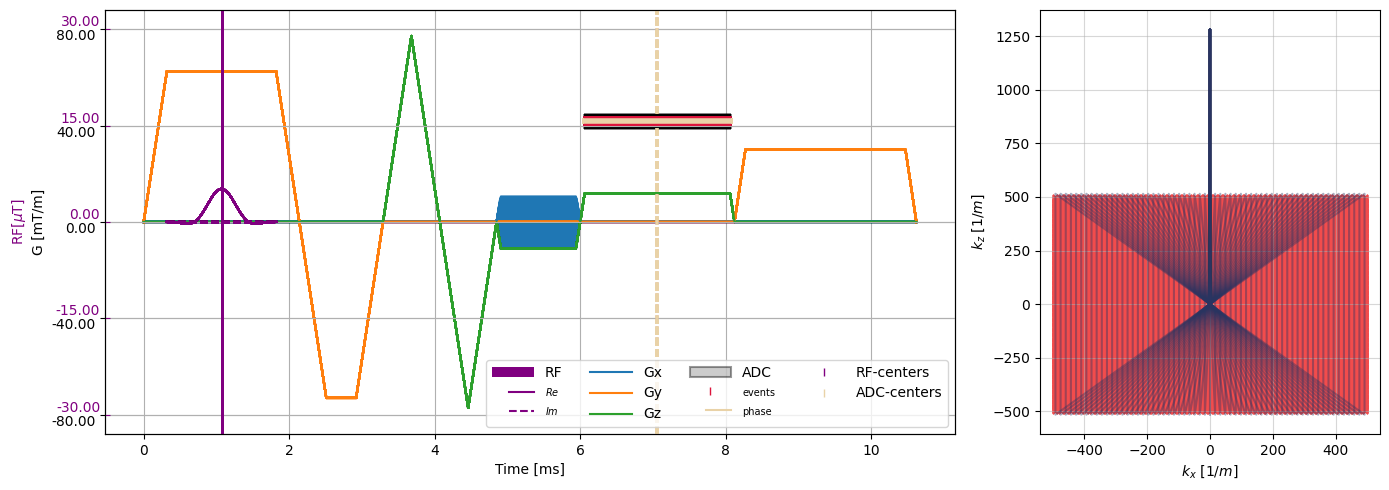

In [6]:
	
rot_matrix = cmrseq.utils.get_rotation_matrix(slice_normal, readout_direction, target_orientation='xyz')

for seq in sequence_list:
    seq.rotate_gradients(rot_matrix)
    
_, k_adc, t_adc = sequence_list[0].calculate_kspace()


plt.close("all")
f, (a1, a2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [5, 2]})
cmrseq.plotting.plot_sequence(sequence_list[0], axes=a1, adc_yoffset=15.7)
for s in sequence_list[1:]:
    cmrseq.plotting.plot_sequence(s, axes=[f.axes[-1], a1, a1, a1], format_axes=False, adc_yoffset=15.7, legend_position="lower right")
    
for s in sequence_list:
    cmrseq.plotting.plot_kspace_2d(s, ax=a2, k_axes=[0, 1])
f.tight_layout()

## Set up Phantom

### Load mesh


In [7]:
# Load Aorta Example.
mesh = pyvista.read("../example_resources/steady_stenosis.vtk")

# The velocity [m/s] is stored in the mesh as U1. In cmrsim all definitions are done in [ms] therefore
# We add the velocity field as scaled data to the mesh 
mesh["velocity"] = Quantity(mesh["U"], "m/s").m_as("m/ms")

# To match the usual geometry (Head <-> Foot along z-axis) flip the axes of the mesh
mesh.points = mesh.points[:, [2, 1, 0]]
mesh.points[:, 1:] *= -1
mesh["velocity"] = mesh["velocity"][:, [2, 1, 0]]
mesh["velocity"][:, 1:] *= -1
global_mesh_offset = [0.0, 0.0, 0.1]
mesh.translate(global_mesh_offset, inplace=True)
mesh = mesh.cell_data_to_point_data()

# clip to restricted length to reduce mesh-size
mesh.clip(normal='z', origin=[0., 0., 0.11], inplace=True)
mesh.clip(normal='-z', origin=[0., 0., -0.10], inplace=True)

UnstructuredGrid (0x7f39d85de860)
  N Cells:    877450
  N Points:   897024
  X Bounds:   -1.500e-02, 1.500e-02
  Y Bounds:   -1.500e-02, 1.500e-02
  Z Bounds:   -1.000e-01, 1.000e-01
  N Arrays:   2

### Instantiate Refilling dataset

In [8]:
# Setup flow dataset with seeding mesh information
particle_creation_fncs = {"magnetization": part_factory.norm_magnetization(),
                          "T1": part_factory.uniform(default_value=250.),
                          "T2": part_factory.uniform(default_value=50.),
                          "M0": part_factory.uniform(default_value=1/seeding_particle_density)}
    
dataset = cmrsim.datasets.RefillingFlowDataset(mesh,
                                               particle_creation_callables=particle_creation_fncs,
                                               slice_position=seeding_slice_position.m_as("m"),
                                               slice_normal=seeding_slice_normal,
                                               slice_thickness=seeding_slice_thickness.m_as("m"),
                                               slice_bounding_box=seeding_slice_bb.m_as("m"),
                                               seeding_vol_spacing=seeding_pixel_spacing,
                                               lookup_map_spacing=lookup_map_spacing,
                                               field_list=[("velocity", 3)])

lookup_table_3d, map_dimensions = dataset.get_lookup_table()
trajectory_module = cmrsim.trajectory.FlowTrajectory(velocity_field=lookup_table_3d.astype(np.float32),
                                                     map_dimensions=map_dimensions.astype(np.float32),
                                                     additional_dimension_mapping=dataset.field_list[1:],
                                                     device='GPU')

Updated Mesh
Updated Slice Position


### Visualize 

Legend: 
- Red box: Slice selective excitation
- White Plane: Imaging plane
- Orange Box: Re-seeding volume 

CMRSeq UnitStrippedWarning: /usr/local/lib/python3.11/dist-packages/pyvista/core/pointset.py:214 : The unit of the quantity is stripped when downcasting to ndarray.
I0000 00:00:1712909610.067931 2951990 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


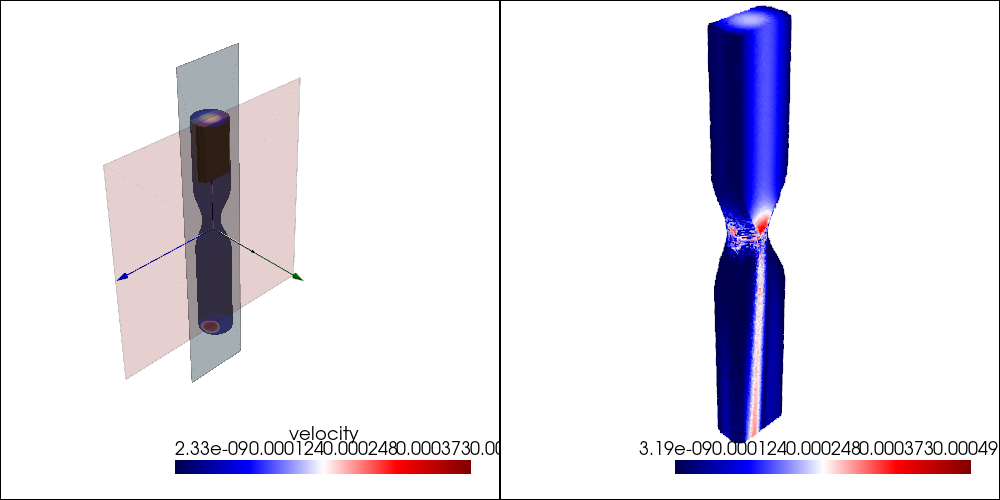

In [9]:
pyvista.close_all()

pyvista.start_xvfb()
plotter = pyvista.Plotter(notebook=True, window_size=(1000, 500), shape=(1, 2))

# Plot axes at origin
origin_arrows = [pyvista.Arrow(start=(0., 0., 0.), direction=direction, tip_length=0.1, tip_radius=0.025, 
                               tip_resolution=10, shaft_radius=0.005, shaft_resolution=10, scale=0.1) 
                 for direction in [(1., 0., 0.), (0., 1., 0.), (0., 0., 1.)]]
plotter.add_mesh(origin_arrows[0], color="blue", label="x")
plotter.add_mesh(origin_arrows[1], color="green", label="y")
plotter.add_mesh(origin_arrows[2], color="red", label="z")

# Plot input mesh
plotter.add_mesh(mesh, scalars="velocity", opacity=0.6, colormap="seismic")

# Plot slice selective RF
_scale = 0.1
rf_mesh = pyvista.Box(bounds=(-_scale, _scale, -_scale, _scale, -slice_thickness.m_as("m")/2, slice_thickness.m_as("m")/2))
rf_mesh.points = cmrseq.utils.mps_to_xyz(rf_mesh.points[np.newaxis], slice_normal=slice_normal, readout_direction=np.array([1., 0., 0.]))[0]
rf_mesh.translate(slice_position, inplace=True)
plotter.add_mesh(rf_mesh, opacity=0.1, show_edges=True, color="red")

# Plot projection plane of the cartesian image slice with M-S directions
image_slice_mesh = pyvista.Box(bounds=(-fov[0].m_as("m")/2, fov[0].m_as("m")/2, -fov[1].m_as("m")/2, fov[1].m_as("m")/2, 0.081, 0.081))
image_slice_mesh.points = cmrseq.utils.xyz_to_mps(image_slice_mesh.points[np.newaxis], slice_normal=slice_normal, readout_direction=readout_direction)[0]
readout_glyph = pyvista.Arrow(start=slice_position.m_as("m"), direction=readout_direction, tip_length=0.1, tip_radius=0.025, 
                              tip_resolution=10, shaft_radius=0.01, shaft_resolution=10, scale=0.05)
slice_selection_glyph = pyvista.Arrow(start=slice_position.m_as("m"), direction=slice_normal, tip_length=0.1, tip_radius=0.025, 
                                      tip_resolution=10, shaft_radius=0.01, shaft_resolution=10, scale=0.05)

plotter.add_mesh(image_slice_mesh, opacity=0.3, show_edges=True)
plotter.add_mesh(readout_glyph, color="black")
plotter.add_mesh(slice_selection_glyph, color="black")

# Plot the slice in which the re-seeding is performed
plotter.add_mesh(dataset.gridded_seeding_volume, color="orange", opacity=1, show_edges=False)

# Plot seeded particles
plotter.subplot(0, 1)
initial_position, _ = dataset.initial_filling(particle_density=8, slice_dictionary=dict(slice_normal=seeding_slice_normal,
                                              slice_position=seeding_slice_position.m_as("m"), slice_thickness=seeding_slice_thickness.m_as("m")))

pos, additional_fields = trajectory_module(initial_position, timing=np.array([0, 0.05]), dt_max=0.01, return_velocities=True)
plotter.add_mesh(pyvista.PolyData(initial_position), scalars=additional_fields[-1]["velocity"], cmap="seismic")
plotter.show(jupyter_backend='static')

## Simulation

After each TR, the RefillingDataset re-seeds particles to compensate the outflow. 

In [10]:
	
time_rf, rf_grid, grad_grid, adc_on_grid = [np.stack(v) for v in cmrseq.utils.grid_sequence_list(sequence_list, force_uniform_grid=False)]
print("Input shapes for Bloch Module:\n  ", "\n   ".join([f"{time_rf.shape=}", f"{rf_grid.shape=}", 
                                                          f"{grad_grid.shape=}", f"{adc_on_grid.shape=}"]))

module = cmrsim.bloch.GeneralBlochOperator(name="rf", gamma=system_specs.gamma_rad.m_as("rad/mT/ms"),
                                           time_grid=time_rf[0], gradient_waveforms=grad_grid,
                                           rf_waveforms=rf_grid, adc_events=adc_on_grid, device="GPU:0")

initial_position, properties = dataset.initial_filling(particle_density=seeding_particle_density,
                                                       slice_dictionary=dict(slice_normal=seeding_slice_normal,
                                                                             slice_position=seeding_slice_position.m_as("m"), 
                                                                             slice_thickness=seeding_slice_thickness.m_as("m")))
print(initial_position.shape, time_rf.shape)
n_samples = tf.shape(module.time_signal_acc[0])[0]
n_repetitions = tf.shape(module.gradient_waveforms)[0]

r = initial_position
for rep_idx in tqdm(range(time_rf.shape[0])):
    m = properties.pop("magnetization")
    m, r = module(trajectory_module=trajectory_module, initial_position=r, magnetization=m,
                  repetition_index=rep_idx, run_parallel=False, **properties)
    properties["magnetization"] = m.numpy()
    r, properties, _ = dataset(particle_density=seeding_particle_density, residual_particle_pos=r.numpy(),
                               particle_properties=properties, distance_tolerance=0.2, reseed_threshold=0.5)

Input shapes for Bloch Module:
   time_rf.shape=(61, 1361)
   rf_grid.shape=(61, 1361)
   grad_grid.shape=(61, 1361, 3)
   adc_on_grid.shape=(61, 1361, 2)
(1215447, 3) (61, 1361)


  0%|          | 0/61 [00:00<?, ?it/s]

## Reconstruct Image

In [11]:
time_signal = tf.stack(module.time_signal_acc, axis=0).numpy().reshape(matrix_size[::-1])
image = tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(time_signal, axes=(0, 1))), axes=(0, 1)).numpy()
centered_projection = tf.signal.fft(time_signal).numpy()
centered_k_space = tf.signal.fft(centered_projection).numpy()
time_per_seg = t_adc - t_adc[matrix_size[0]//2+1]
freq_per_seg = np.fft.fftfreq(n=time_per_seg.shape[0], d=time_per_seg[1]-time_per_seg[0])

print(time_signal.shape, image.shape)

(61, 301) (61, 301)


In [ ]:
# Plot 2D Lines
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
[a.grid(True) for a in axes]
[a.set_title(t) for a, t in zip(axes, ["temporal signal", "spectrum", "k-space line", "spatial projection"])]
[a.legend(["real", "Imaginary"]) for a in axes]
for ky in range(0, time_signal.shape[0], 10):
    axes[0].plot(time_per_seg, np.real(time_signal[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[0].plot(time_per_seg, np.imag(time_signal[ky]), color="C1", linestyle="-", alpha=0.7)
    axes[1].plot(freq_per_seg, np.real(centered_projection[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[1].plot(freq_per_seg, np.imag(centered_projection[ky]), color="C1", linestyle="-", alpha=0.7)
    axes[2].plot(np.arange(freq_per_seg.shape[0]), np.real(centered_k_space[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[2].plot(np.arange(freq_per_seg.shape[0]), np.imag(centered_k_space[ky]), color="C1", linestyle="-", alpha=0.7)
    axes[3].plot(np.arange(freq_per_seg.shape[0]), np.real(image[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[3].plot(np.arange(freq_per_seg.shape[0]), np.imag(image[ky]), color="C1", linestyle="-", alpha=0.7)
fig.tight_layout()

In [ ]:
# Plot all PE-lines in 3D
plt.close("all")
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig, axes = plt.subplots(1, 4, subplot_kw={'projection': '3d'}, figsize=(18, 4))
[a.set_title(t) for a, t in zip(axes, ["temporal signal", "spectrum", "k-space line", "spatial projection"])]

for ky in range(time_signal.shape[0]):
    axes[0].plot(time_per_seg, np.ones_like(time_signal[ky].real) * ky, np.abs(time_signal[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[1].plot(freq_per_seg, np.ones_like(centered_projection[ky].real) * ky, np.abs(centered_projection[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[2].plot(np.arange(freq_per_seg.shape[0]), np.ones_like(centered_k_space[ky].real) * ky, np.abs(centered_k_space[ky]), color="C0", linestyle="-", alpha=0.7)
    axes[3].plot(np.arange(freq_per_seg.shape[0]), np.ones_like(image[ky].real) * ky, np.abs(image[ky]), color="C0", linestyle="-", alpha=0.7)
fig.tight_layout()

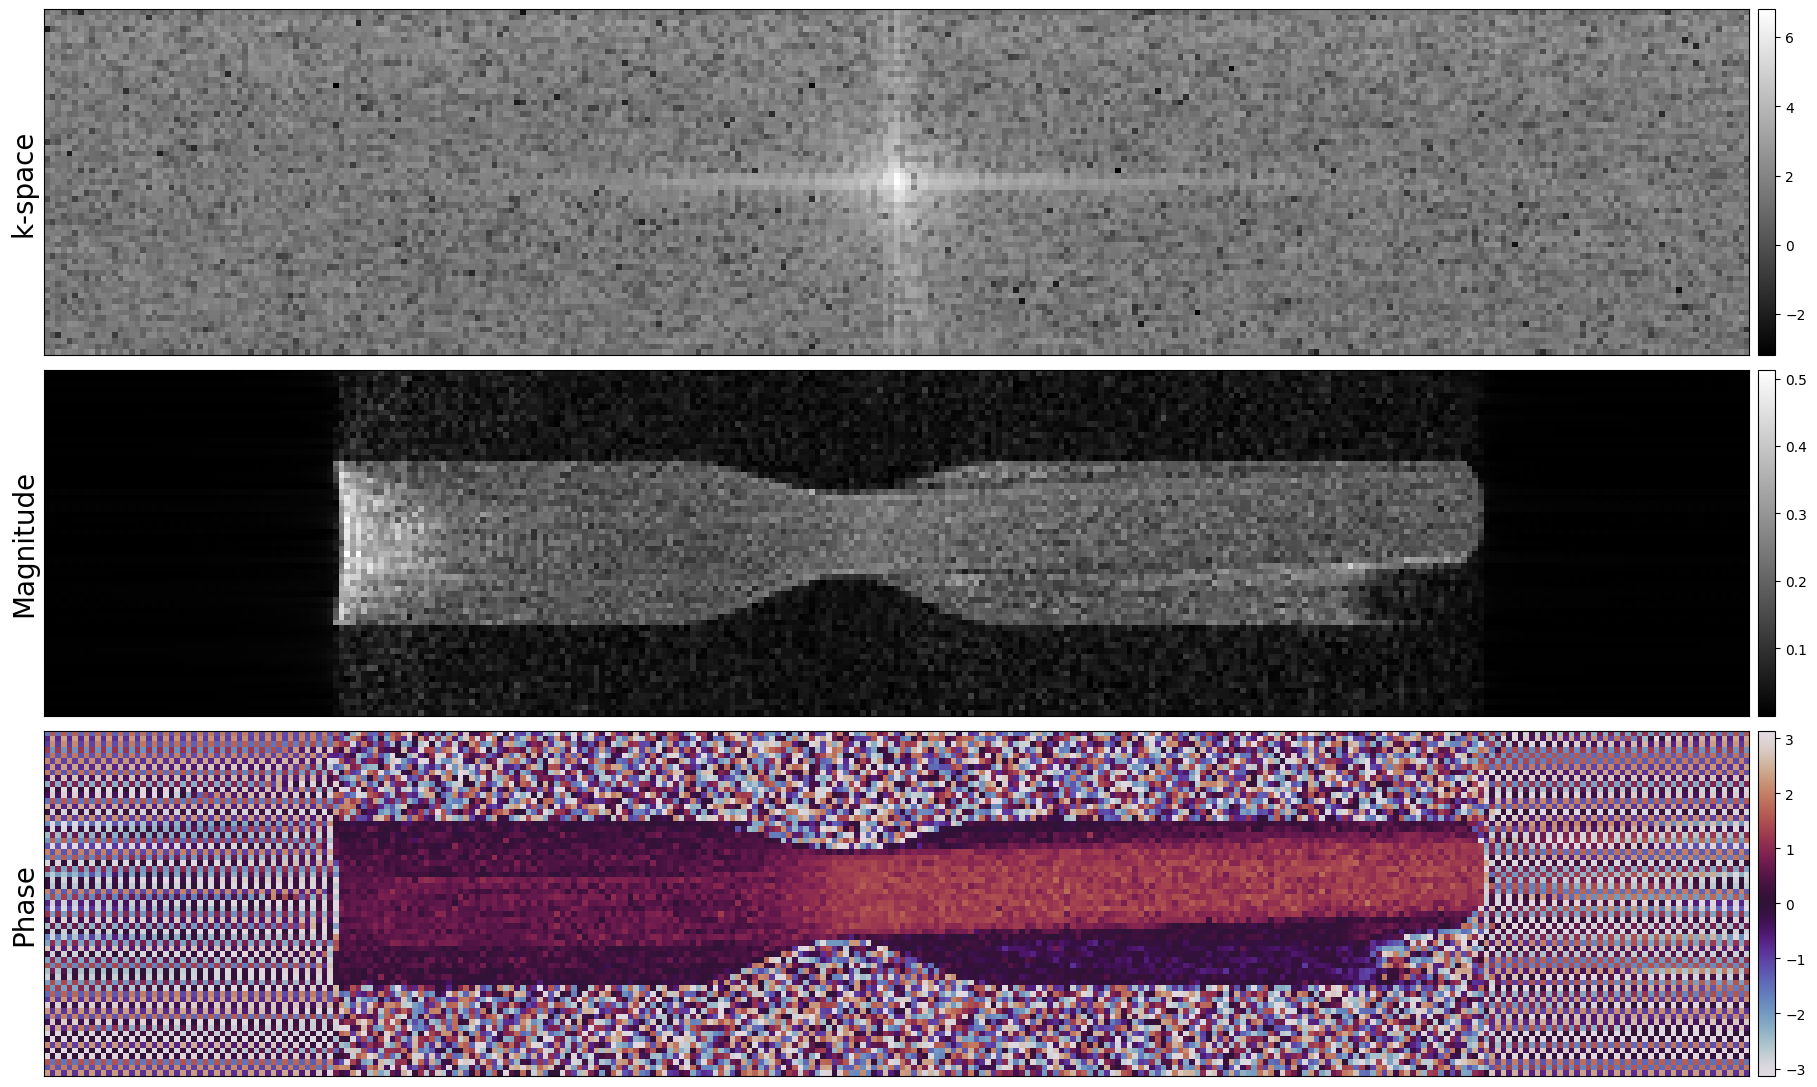

In [12]:
# Show images
fig, axes = plt.subplots(3, 1, figsize=(18, 11))

kspace_plot = axes[0].imshow(np.log(np.abs(np.squeeze(time_signal))), cmap="gray")
fig.colorbar(kspace_plot, ax=axes[0], fraction=0.015, pad=0.005)
abs_plot = axes[1].imshow(np.abs(np.squeeze(image)), cmap="gray")
fig.colorbar(abs_plot, ax=axes[1], fraction=0.015, pad=0.005)
phase_plot = axes[2].imshow(np.angle(np.squeeze(image)), cmap="twilight", vmin=-np.pi, vmax=np.pi)
fig.colorbar(phase_plot, ax=axes[2], fraction=0.015, pad=0.005)
[(_.set_yticks([]), _.set_xticks([])) for _ in axes]
[_.set_ylabel(t, fontsize=20) for _, t in zip(axes, ["k-space", "Magnitude", "Phase"])]
fig.tight_layout()